In [1]:
import os
#if not os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#    raise 'stop'
if not os.path.isdir('d:/flagellar/'):
    deps_path = '/kaggle/usr/lib/flg-packages/'
    !pip install --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt
    !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
    !pip install --no-index --find-links=./packages ultralytics
    !rm -rf ./packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

fast_mode = False
if fls.is_submission:
    fast_mode = False

MainProcess


In [3]:
all_data = fls.load_all_train_data()+fls.load_all_extra_data()

In [4]:
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
test_data = test_data
if fast_mode:
    train_data = train_data[1:10]
    test_data = test_data[1:10]
len(train_data), len(test_data)

(1444, 200)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


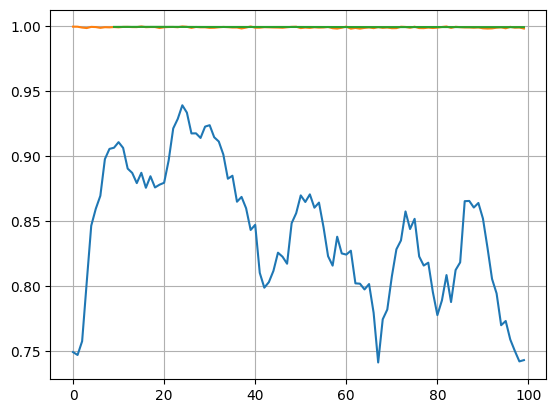

100 101 102 103 104 105 

In [ ]:
model_name = "unet_extradata_refactored.pickle"
model = flg_model.ThreeStepModel()
if fast_mode: model.step1Heatmap.n_epochs = 100
model.step2Labels.threshold = -2.
model.step1Heatmap.learning_rate = 1e-3
model.run_in_parallel = True
model.step1Heatmap.plot_every = 100
model.train(train_data, test_data)
if not fls.env=='kaggle' and not fast_mode:
    fls.dill_save(fls.model_dir+ model_name, model)

In [ ]:
if not fls.is_submission:
    inferred_test_data = model.infer(test_data)
    print(fls.score_competition_metric(inferred_test_data, test_data))
    print(fls.create_submission_dataframe(inferred_test_data, test_data))

In [ ]:
%debug

In [ ]:
importlib.reload(flg_unet)
if not fls.env=='kaggle' and not fast_mode:
    model = fls.dill_load(fls.model_dir+model_name)
model.run_in_parallel = fls.env=='kaggle'
test_data2 = fls.load_all_test_data()
inferred_test_data2 = model.infer(test_data2)
fls.write_submission_file(inferred_test_data2)